Code in this jupyter notebook contains my contribution to the Crime Trends in the Atlanta Area 2009-2020 project. Important areas and observations are annotated. Not all graphs were used in the presentation but all were important for overall analysis.


In [1]:

import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import requests
import json
import seaborn as sns


In [2]:
#Import the data from the combined APD csv files - from Grace's export
csvpath_09_20_clean = os.path.join("Resources", "crime_09_20_clean.csv")


In [3]:
#Convert to dataframe and display
crime_09_20_clean_df = pd.read_csv(csvpath_09_20_clean, encoding="utf-8", low_memory=False)
crime_09_20_clean_df

,offense_id,occur_date,occur_time,location,UC2_Literal,ibr_code,neighborhood,lat,long,occur_year,occur_month
0,193651657.0,12/31/2019,1458,1388 LA FRANCE ST NE,LARCENY-NON VEHICLE,2308,Edgewood,33.76053,-84.34220,2019,12
1,193651031.0,12/31/2019,1300,443 MORELAND AVE SE,LARCENY-NON VEHICLE,2302,Ormewood Park,33.74179,-84.34973,2019,12
2,193650870.0,12/31/2019,1200,2711 METROPOLITAN PKWY SW,LARCENY-NON VEHICLE,2303,Hammond Park,33.68092,-84.40814,2019,12
3,193651019.0,12/31/2019,1300,969 MARIETTA ST NW,LARCENY-NON VEHICLE,2303,Marietta Street Artery,33.77828,-84.40910,2019,12
4,193651039.0,12/31/2019,1300,3070 BOLLING WAY NE,LARCENY-NON VEHICLE,2303,Buckhead Village,33.83888,-84.37995,2019,12
...,...,...,...,...,...,...,...,...,...,...,...
364417,200011298.0,1/1/2020,14:45,2630 MARTIN L KING JR DR SW,AUTO THEFT,NaN,Harland Terrace,33.75377,-84.47405,2020,1
364418,200011823.0,1/1/2020,20:00,540 HUMPHRIES ST SW,AUTO THEFT,NaN,Mechanicsville,33.73990,-84.40488,2020,1
364419,200020105.0,1/1/2020,21:45,1174 EUCLID AVE NE,AUTO THEFT,NaN,Inman Park,33.76553,-84.34934,2020,1
364420,200020704.0,1/1/2020,20:00,383 RALPH MCGILL BLVD NE,AUTO THEFT,NaN,Old Fourth Ward,33.76391,-84.37489,2020,1


In [4]:
#Sort by offense id
offense_sort = crime_09_20_clean_df.sort_values("offense_id", ascending = False)
# offense_sort

#Check for repeat offense id
crime_09_20_clean_df["offense_id"].nunique()


364109

In [5]:
#Count how many rows we have per year in original df to compare after duplicate drop - make sure dups are not only appearing
#in one or two particular years to raise a red flag
group_year = crime_09_20_clean_df.groupby(['occur_year']).count()
group_year

,offense_id,occur_date,occur_time,location,UC2_Literal,ibr_code,neighborhood,lat,long,occur_month
occur_year,,,,,,,,,,
2009,39326,39326,39326,39326,39326,39323,38028,39326,39326,39326
2010,35529,35529,35529,35529,35529,35525,34259,35529,35529,35529
2011,34852,34852,34852,34852,34852,34725,33551,34852,34852,34852
2012,33382,33382,33382,33382,33382,33376,32105,33382,33382,33382
2013,32398,32398,32398,32397,32398,32393,31311,32398,32398,32398
2014,31115,31115,31115,31115,31115,31112,30038,31115,31115,31115
2015,30058,30058,30058,30057,30058,30054,28936,30058,30058,30058
2016,29006,29006,29006,29006,29006,29005,27857,29006,29006,29006
2017,26386,26386,26386,26386,26386,26385,25453,26386,26386,26386


In [6]:

# Get duplicates into a variable.
duplicates = crime_09_20_clean_df[crime_09_20_clean_df.duplicated(subset=["offense_id", "occur_year","occur_time",
                                                                          "UC2_Literal", "location"])] 
print(duplicates)
#174 rows

# Pull a specific offense id and check where it's duplicated.
offense_193621541 = crime_09_20_clean_df.loc[(crime_09_20_clean_df["offense_id"]==193621541)]
print(offense_193621541)


         offense_id  occur_date occur_time                    location  \
185     193621541.0  12/28/2019       1745           2854 GRAND AVE SW   
822     193522385.0  12/18/2019       2210           445 MARKHAM ST SW   
2486    193302001.0  11/26/2019       1915       426 E RHINEHILL RD SE   
4812    193051223.0  10/25/2019       1200              521 TIFT ST SW   
6173    192782336.0   10/5/2019       2200  722 HILLSIDE VILLAGE DR SE   
...             ...         ...        ...                         ...   
343550  203530800.0  12/18/2020      12:35  737 S PONCE DE LEON AVE NE   
347202  203081476.0   11/3/2020      17:42  777 S PONCE DE LEON AVE NE   
347793  203020020.0  10/27/2020      20:00  777 S PONCE DE LEON AVE NE   
348621  202900817.0  10/16/2020      11:50  737 S PONCE DE LEON AVE NE   
352534  202241575.0   8/11/2020      19:00     916 CAPITOL VIEW AVE NW   

                 UC2_Literal ibr_code               neighborhood        lat  \
185              AGG ASSAULT    


Note duplicates may occur due to ibr_code issues. We are not using that column for our analysis, we should delete that column.
Also sometimes duplicate IDs occur due to differing UC2_Literal entries. We want those - multiple crimes at one spot!

In [7]:
#Drop the ibr_code column 
crime_no_ibr_df = crime_09_20_clean_df.drop("ibr_code", inplace = False, axis = 1)

#Put duplicates into a variable 
duplicates = crime_no_ibr_df[crime_no_ibr_df.duplicated(subset=["offense_id", "occur_year",
                                                                "occur_time", "UC2_Literal", "location"])]
#Display duplicates
print(duplicates)


         offense_id  occur_date occur_time                    location  \
185     193621541.0  12/28/2019       1745           2854 GRAND AVE SW   
822     193522385.0  12/18/2019       2210           445 MARKHAM ST SW   
2486    193302001.0  11/26/2019       1915       426 E RHINEHILL RD SE   
4812    193051223.0  10/25/2019       1200              521 TIFT ST SW   
6173    192782336.0   10/5/2019       2200  722 HILLSIDE VILLAGE DR SE   
...             ...         ...        ...                         ...   
343550  203530800.0  12/18/2020      12:35  737 S PONCE DE LEON AVE NE   
347202  203081476.0   11/3/2020      17:42  777 S PONCE DE LEON AVE NE   
347793  203020020.0  10/27/2020      20:00  777 S PONCE DE LEON AVE NE   
348621  202900817.0  10/16/2020      11:50  737 S PONCE DE LEON AVE NE   
352534  202241575.0   8/11/2020      19:00     916 CAPITOL VIEW AVE NW   

                 UC2_Literal               neighborhood        lat       long  \
185              AGG ASSAULT  


Duplicates are 174 rows -  now delete them

In [8]:
#Drop the duplicates
crime_no_ibr_df.drop_duplicates(["offense_id", "occur_year", "occur_time", "UC2_Literal", "location"], inplace = True)

#list of the duplicated offenses
duplicate_list = duplicates.loc[:,"offense_id"].unique()
duplicate_list


array([1.93621541e+08, 1.93522385e+08, 1.93302001e+08, 1.93051223e+08,
       1.92782336e+08, 1.91901234e+08, 1.91841501e+08, 1.91732212e+08,
       1.91652173e+08, 1.91612131e+08, 1.90800450e+08, 1.83242277e+08,
       1.82782034e+08, 1.81951904e+08, 1.81450624e+08, 1.80490058e+08,
       1.73032162e+08, 1.72872007e+08, 1.72222749e+08, 1.72070629e+08,
       1.71570931e+08, 1.71102649e+08, 1.70892557e+08, 1.70780462e+08,
       1.70721513e+08, 1.70471026e+08, 1.70281450e+08, 1.70231299e+08,
       1.70220467e+08, 1.63622379e+08, 1.63590355e+08, 1.63140668e+08,
       1.63062304e+08, 1.62940662e+08, 1.62841776e+08, 1.62680362e+08,
       1.62551798e+08, 1.62490646e+08, 1.62350567e+08, 1.62021073e+08,
       1.61893131e+08, 1.61702767e+08, 1.61671338e+08, 1.61481137e+08,
       1.61112712e+08, 1.61082554e+08, 1.60462679e+08, 1.60300393e+08,
       1.60051549e+08, 1.53320375e+08, 1.53132754e+08, 1.52963147e+08,
       1.52560107e+08, 1.52512817e+08, 1.52291871e+08, 1.51612311e+08,
      

In [9]:
#Display new dataframe after dropping duplicates and check row number
crime_no_ibr_df


,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_year,occur_month
0,193651657.0,12/31/2019,1458,1388 LA FRANCE ST NE,LARCENY-NON VEHICLE,Edgewood,33.76053,-84.34220,2019,12
1,193651031.0,12/31/2019,1300,443 MORELAND AVE SE,LARCENY-NON VEHICLE,Ormewood Park,33.74179,-84.34973,2019,12
2,193650870.0,12/31/2019,1200,2711 METROPOLITAN PKWY SW,LARCENY-NON VEHICLE,Hammond Park,33.68092,-84.40814,2019,12
3,193651019.0,12/31/2019,1300,969 MARIETTA ST NW,LARCENY-NON VEHICLE,Marietta Street Artery,33.77828,-84.40910,2019,12
4,193651039.0,12/31/2019,1300,3070 BOLLING WAY NE,LARCENY-NON VEHICLE,Buckhead Village,33.83888,-84.37995,2019,12
...,...,...,...,...,...,...,...,...,...,...
364417,200011298.0,1/1/2020,14:45,2630 MARTIN L KING JR DR SW,AUTO THEFT,Harland Terrace,33.75377,-84.47405,2020,1
364418,200011823.0,1/1/2020,20:00,540 HUMPHRIES ST SW,AUTO THEFT,Mechanicsville,33.73990,-84.40488,2020,1
364419,200020105.0,1/1/2020,21:45,1174 EUCLID AVE NE,AUTO THEFT,Inman Park,33.76553,-84.34934,2020,1
364420,200020704.0,1/1/2020,20:00,383 RALPH MCGILL BLVD NE,AUTO THEFT,Old Fourth Ward,33.76391,-84.37489,2020,1


364422 original number of rows, dropped 174 rows as expected

In [10]:
#Check for repeat offense id 

crime_no_ibr_df["offense_id"].nunique()

364109

Number of unique is less than the number of rows in the df; equals 139 duplicated offense ids due to two crimes occurring at the same location at the same time, which is valid data to keep.

In [11]:
#Compare year counts to original above after dropping duplicates
group_year_dups_removed = crime_no_ibr_df.groupby(['occur_year']).count()
group_year_dups_removed

,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_month
occur_year,,,,,,,,,
2009,39297,39297,39297,39297,39297,38000,39297,39297,39297
2010,35501,35501,35501,35501,35501,34231,35501,35501,35501
2011,34833,34833,34833,34833,34833,33534,34833,34833,34833
2012,33370,33370,33370,33370,33370,32093,33370,33370,33370
2013,32389,32389,32389,32388,32389,31302,32389,32389,32389
2014,31104,31104,31104,31104,31104,30028,31104,31104,31104
2015,30046,30046,30046,30045,30046,28925,30046,30046,30046
2016,28986,28986,28986,28986,28986,27838,28986,28986,28986
2017,26373,26373,26373,26373,26373,25440,26373,26373,26373


Changes across years look fairly even; no red flags.

In [12]:
#Export the df with duplicates dropped to a csv for everyone
crime_no_ibr_df.to_csv("Resources/crime_09_20_clean_dupsdeleted.csv", index=False, header=True)


In [13]:
#Get overall number of crimes reported per year for plotting
year_counts = crime_no_ibr_df["occur_year"].value_counts()
print(year_counts)

#Convert to df and add a separate index column
year_counts_df = pd.DataFrame(year_counts).reset_index()

#Rename columns
year_counts_df = year_counts_df.rename(columns={"index": "Year", "occur_year": "Reported Crimes"})
year_counts_df


2009    39297
2010    35501
2011    34833
2012    33370
2013    32389
2014    31104
2015    30046
2016    28986
2017    26373
2018    25606
2019    24842
2020    21901
Name: occur_year, dtype: int64


,Year,Reported Crimes
0,2009,39297
1,2010,35501
2,2011,34833
3,2012,33370
4,2013,32389
5,2014,31104
6,2015,30046
7,2016,28986
8,2017,26373
9,2018,25606


In [14]:
#Make a loop to calculate the percent change year by year using the dataframe created above

#Set variable for the column for easier navigation
number_crimes = year_counts_df["Reported Crimes"]

#Set an empty list to collect the percent changes
percent_change = []

#Loop through based on the column length
for i in range(len(number_crimes)):
    
    #First number in the list will be zero, since there is no percent change for the first year
    if i==0:
        percent_change.append(0)
    
    #Locate next row down, subtract previous row, divide by previous row and multiply by 100. Append list with calculations
    #Needs to stop at 2nd to last row
    if i <= (len(number_crimes)-2):
        percent = ((year_counts_df.iloc[(i+1),1] - year_counts_df.iloc[i,1])/year_counts_df.iloc[i,1] * 100)
        percent_change.append(percent)

#Make a copy of the original dataframe so it isn't modified
percent_change_year_counts_df = year_counts_df.copy()

#Add the percentage column to the new dataframe
percent_change_year_counts_df.insert(2, "Percent Change", percent_change)

#Change the percent column to numeric
percent_change_year_counts_df["Percent Change"] = pd.to_numeric(percent_change_year_counts_df["Percent Change"])

#Take the absolule value to get rid of negative numbers
percent_change_year_counts_df["Percent Change"] = percent_change_year_counts_df["Percent Change"].abs()

#Format the percentage column
percent_change_year_counts_df["Percent Change"] = percent_change_year_counts_df["Percent Change"].map("{:,.0f}%".format)

#Display the new df
percent_change_year_counts_df



,Year,Reported Crimes,Percent Change
0,2009,39297,0%
1,2010,35501,10%
2,2011,34833,2%
3,2012,33370,4%
4,2013,32389,3%
5,2014,31104,4%
6,2015,30046,3%
7,2016,28986,4%
8,2017,26373,9%
9,2018,25606,3%


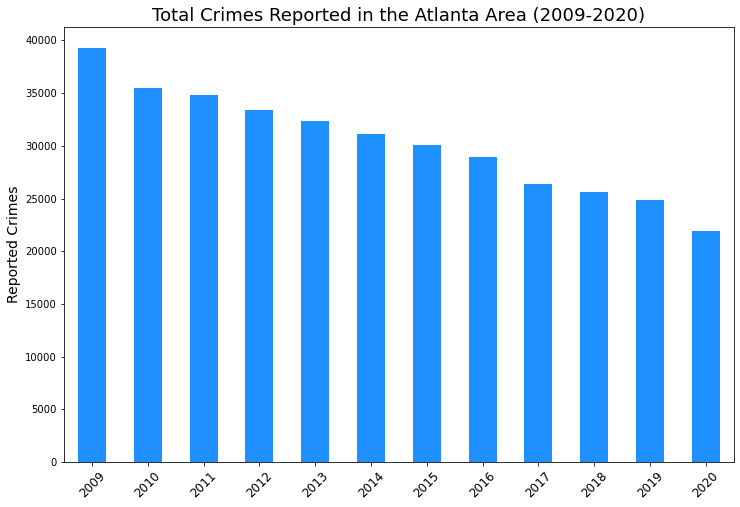

In [15]:
#Plot a bar chart of number of crimes by year
year_counts.plot(kind = "bar", color = "dodgerblue", figsize = (12,8))

#Add title and labels for each axis and set font size. Also set tick labels to sit at 45 degrees
plt.title("Total Crimes Reported in the Atlanta Area (2009-2020)", fontsize = (18))
plt.ylabel("Reported Crimes", fontsize = (14))
plt.xticks(rotation = 45, fontsize = (12))

plt.show()


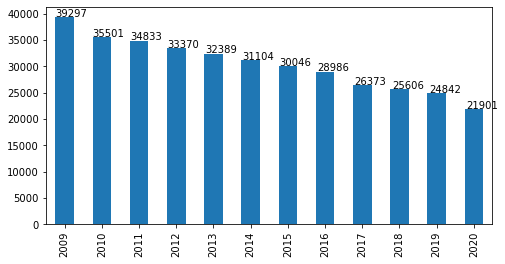

In [16]:
#Plot with pandas/matplotlib to get values above bars
ax = year_counts.plot(kind="bar", figsize=(8,4),legend =False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

#I want to learn this for annotating other values, such as n=? or percent change, etc. Table for later.

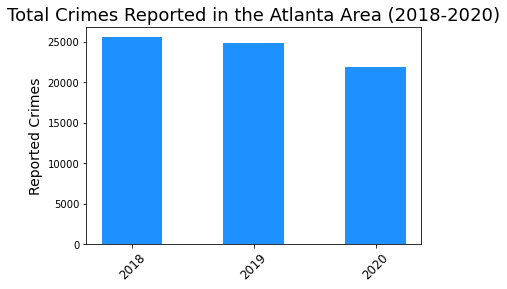

In [17]:
#Just pull 2018, 2019, 2020 for a more concentrated comparison of crime across years
three_years = year_counts_df.loc[(year_counts_df["Year"]==2018) |(year_counts_df["Year"]==2019) | (year_counts_df["Year"]==2020)]

#Set the chart type as bar, x-axis is the Year, y is the number of crimes, set color and width of bars
plt.bar(three_years["Year"], three_years["Reported Crimes"], color = 'dodgerblue', align='center', width=0.5)

#Set placement of tick marks - just doing a pandas plot puts half year tick marks as well....
plt.xticks(three_years["Year"], rotation = 45, fontsize = (12))

#Add title and labels for each axis and set font size. Also set tick labels to sit at 45 degrees
plt.title("Total Crimes Reported in the Atlanta Area (2018-2020)", fontsize = (18))
plt.ylabel("Reported Crimes", fontsize = (14))
plt.xticks(rotation = 45, fontsize = (12))

plt.show()


In [18]:
#Group cleaned dataframe by year and crime, count to show number of offenses for each type of crime
year_offense_group =crime_no_ibr_df.groupby(["occur_year", "UC2_Literal"])['offense_id'].count()

#make year_offense into a dataframe and reset the index
year_offense_df = pd.DataFrame(year_offense_group).reset_index()

year_offense_df

,occur_year,UC2_Literal,offense_id
0,2009,AGG ASSAULT,2589
1,2009,AUTO THEFT,5622
2,2009,BURGLARY-NONRES,1682
3,2009,BURGLARY-RESIDENCE,7393
4,2009,HOMICIDE,77
...,...,...,...
114,2020,HOMICIDE,146
115,2020,LARCENY-FROM VEHICLE,8584
116,2020,LARCENY-NON VEHICLE,4628
117,2020,MANSLAUGHTER,2


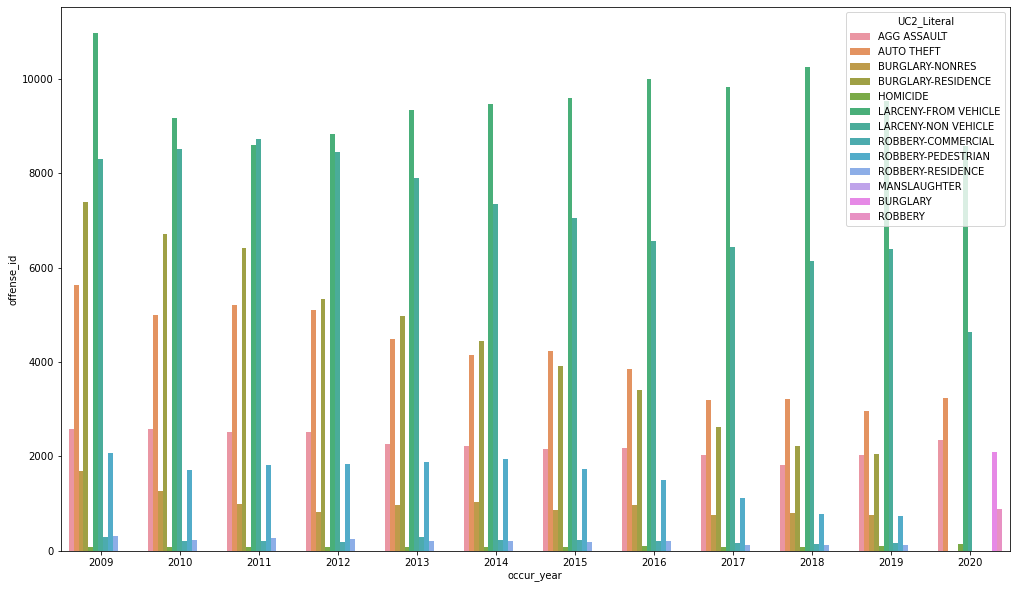

In [19]:
#Plot figure of all years and types of crimes. Will likely be too large to use in presentation or be useful there

#Use Matplotlib to set figure size first
plt.figure(figsize=(17,10))

#Plot with seaborn
sns.barplot(x = 'occur_year', y = 'offense_id', hue = 'UC2_Literal', data = year_offense_df)
plt.show()


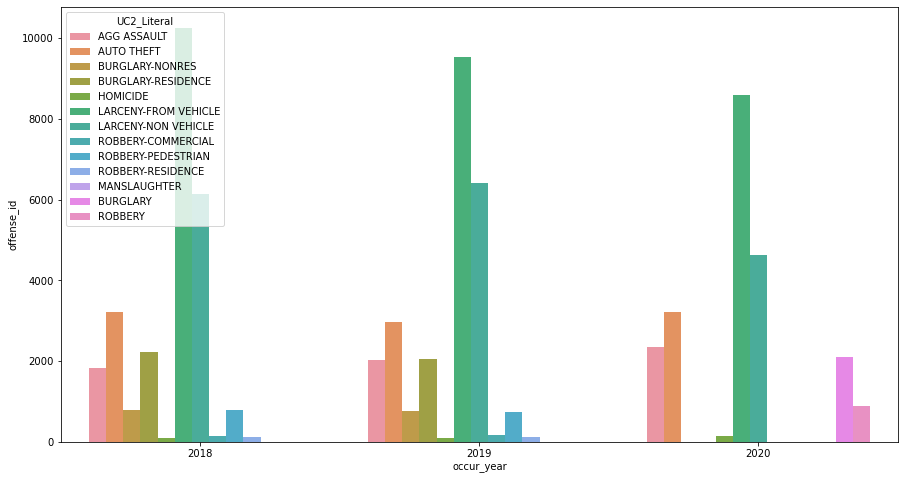

In [20]:
#Select 2018 - 2020 for closer analysis of above
three_years_type = year_offense_df.loc[(year_offense_df["occur_year"]==2018) |(year_offense_df["occur_year"]==2019) | (year_offense_df["occur_year"]==2020)]

#Reset df index
three_years_type_df = three_years_type.reset_index()

#Use Matplotlib to set figure size ahead
plt.figure(figsize=(15,8))

#Plot with seaborn
sns.barplot(x = 'occur_year', y = 'offense_id', hue = 'UC2_Literal', data = three_years_type_df)
plt.show()

Breakdown of robberies and burglaries is not consistent in this data. Look closer at 2020.

In [21]:
#Display and view categories closely for analysis
three_years_type_df


,index,occur_year,UC2_Literal,offense_id
0,90,2018,AGG ASSAULT,1823
1,91,2018,AUTO THEFT,3219
2,92,2018,BURGLARY-NONRES,797
3,93,2018,BURGLARY-RESIDENCE,2226
4,94,2018,HOMICIDE,88
5,95,2018,LARCENY-FROM VEHICLE,10256
6,96,2018,LARCENY-NON VEHICLE,6145
7,97,2018,ROBBERY-COMMERCIAL,148
8,98,2018,ROBBERY-PEDESTRIAN,789
9,99,2018,ROBBERY-RESIDENCE,115


Note that they got lazy in 2020: no longer breaking out burglaries and robberies by type. Consolidate previous years for comparisons.

In [22]:
#Consolidated dataframe headings to match what's going on in 2020 with robberies and burglaries

crime_no_ibr_consolidated_df = crime_no_ibr_df.replace(
    {"BURGLARY-NONRES": "BURGLARY", "BURGLARY-RESIDENCE": "BURGLARY", "ROBBERY-COMMERCIAL" : "ROBBERY",
     "ROBBERY-PEDESTRIAN": "ROBBERY", "ROBBERY-RESIDENCE" : "ROBBERY"})
crime_no_ibr_consolidated_df

,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_year,occur_month
0,193651657.0,12/31/2019,1458,1388 LA FRANCE ST NE,LARCENY-NON VEHICLE,Edgewood,33.76053,-84.34220,2019,12
1,193651031.0,12/31/2019,1300,443 MORELAND AVE SE,LARCENY-NON VEHICLE,Ormewood Park,33.74179,-84.34973,2019,12
2,193650870.0,12/31/2019,1200,2711 METROPOLITAN PKWY SW,LARCENY-NON VEHICLE,Hammond Park,33.68092,-84.40814,2019,12
3,193651019.0,12/31/2019,1300,969 MARIETTA ST NW,LARCENY-NON VEHICLE,Marietta Street Artery,33.77828,-84.40910,2019,12
4,193651039.0,12/31/2019,1300,3070 BOLLING WAY NE,LARCENY-NON VEHICLE,Buckhead Village,33.83888,-84.37995,2019,12
...,...,...,...,...,...,...,...,...,...,...
364417,200011298.0,1/1/2020,14:45,2630 MARTIN L KING JR DR SW,AUTO THEFT,Harland Terrace,33.75377,-84.47405,2020,1
364418,200011823.0,1/1/2020,20:00,540 HUMPHRIES ST SW,AUTO THEFT,Mechanicsville,33.73990,-84.40488,2020,1
364419,200020105.0,1/1/2020,21:45,1174 EUCLID AVE NE,AUTO THEFT,Inman Park,33.76553,-84.34934,2020,1
364420,200020704.0,1/1/2020,20:00,383 RALPH MCGILL BLVD NE,AUTO THEFT,Old Fourth Ward,33.76391,-84.37489,2020,1


In [23]:
#Group new dataframe with consolidated headings by year and crime, count to show number of offenses for each type of crime
year_offense_group_two =crime_no_ibr_consolidated_df.groupby(["occur_year", "UC2_Literal"])['offense_id'].count()

#make year_offense into a dataframe and reset the index
year_offense_two_df = pd.DataFrame(year_offense_group_two).reset_index()

year_offense_two_df

,occur_year,UC2_Literal,offense_id
0,2009,AGG ASSAULT,2589
1,2009,AUTO THEFT,5622
2,2009,BURGLARY,9075
3,2009,HOMICIDE,77
4,2009,LARCENY-FROM VEHICLE,10966
...,...,...,...
81,2020,HOMICIDE,146
82,2020,LARCENY-FROM VEHICLE,8584
83,2020,LARCENY-NON VEHICLE,4628
84,2020,MANSLAUGHTER,2


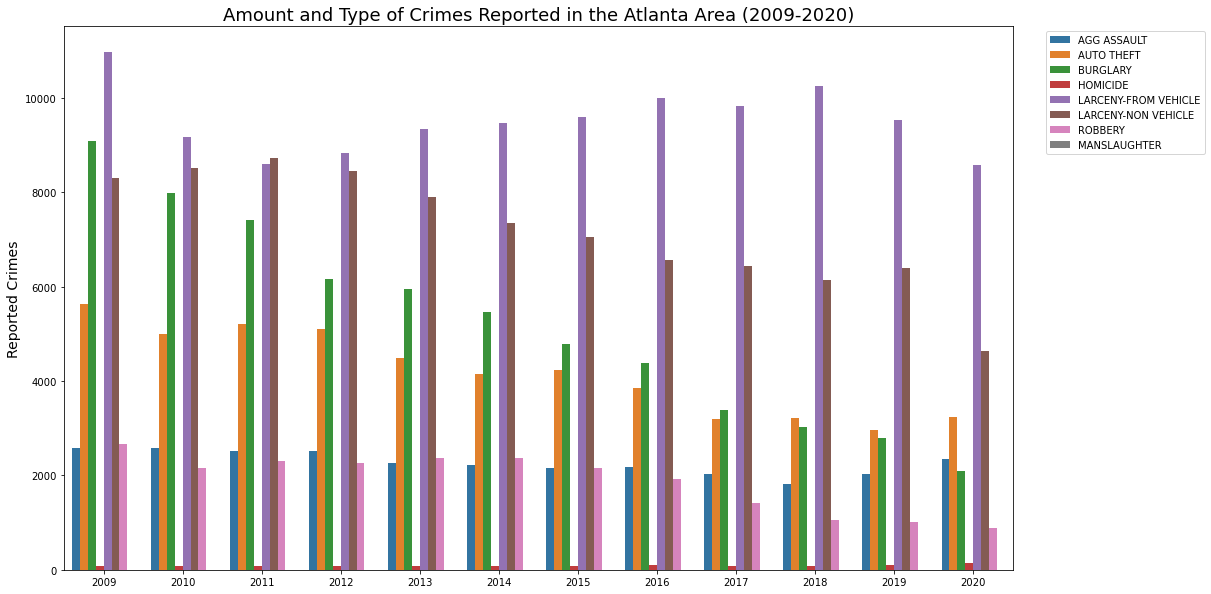

In [24]:
#Plot all years and types of crimes - will be very large

#Set figure size with MatPlotlib
plt.figure(figsize=(17,10))
#Plot with seaborn
sns.barplot(x = 'occur_year', y = 'offense_id', hue = 'UC2_Literal', data = year_offense_two_df)

#Move legend
plt.legend(bbox_to_anchor= (1.03, 1) );

#Add title and labels for each axis and set font size. 
plt.title("Amount and Type of Crimes Reported in the Atlanta Area (2009-2020)", fontsize = (18))
plt.ylabel("Reported Crimes", fontsize = (14))
plt.xlabel("")
plt.show()

All crime headings are now consolidated!

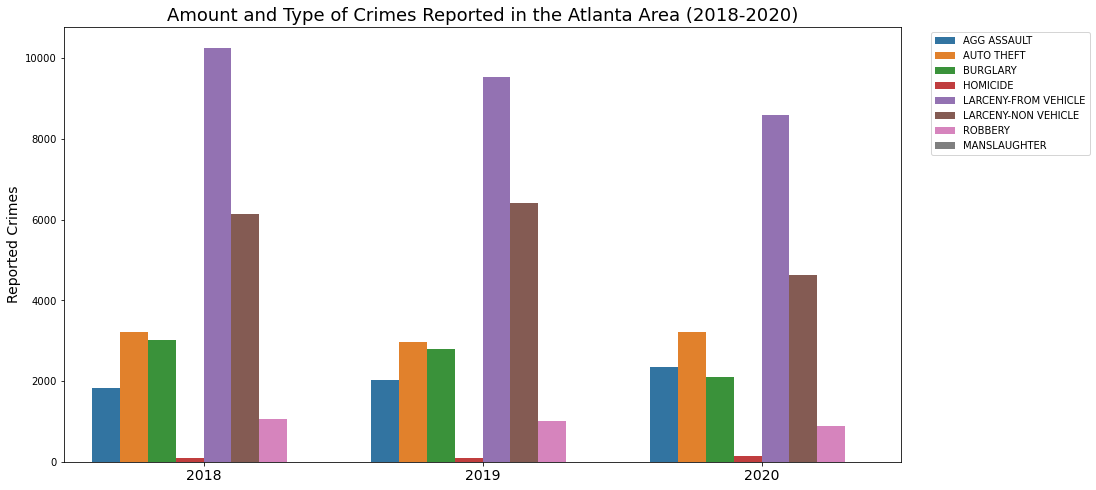

In [25]:
#Select 2018 - 2020 for closer analysis of above
three_years_type_two = year_offense_two_df.loc[(year_offense_two_df["occur_year"]==2018) |(year_offense_two_df["occur_year"]==2019)|(year_offense_two_df["occur_year"]==2020)]

#Reset the index
three_years_type_two_df = three_years_type_two.reset_index()

#Use Matplotlib to set figure size ahead
plt.figure(figsize=(15,8))

#Plot with seaborn
sns.barplot(x = 'occur_year', y = 'offense_id', hue = 'UC2_Literal', data = three_years_type_two_df)

#Move the legend off of the plot to stop it from blocking data
plt.legend(bbox_to_anchor= (1.03, 1) );

#Add title and labels for each axis and set font size. 
plt.title("Amount and Type of Crimes Reported in the Atlanta Area (2018-2020)", fontsize = (18))
plt.ylabel("Reported Crimes", fontsize = (14))
plt.xlabel("")
plt.xticks(fontsize = (14))
plt.show()


Looks much better, but not particularly interesting for display. Looks like burglary has dropped in 2020 as well as larceny.

In [26]:
#Want to bin times for categories, but 2020 data has colon in its time column. Remove colons
crime_no_ibr_consolidated_df['occur_time'] = crime_no_ibr_consolidated_df['occur_time'].astype(str)
crime_no_ibr_consolidated_df["occur_time"] = crime_no_ibr_consolidated_df["occur_time"].replace(":","", regex=True)

#Change the column to numeric for binning
# pd.to_numeric(crime_09_20_clean_df["occur_time"])
#When I run above code, there is a problem at index 48388 - someone entered a T instead of a time. Need to fix

#Confirm the bad row and view
bad_time = crime_no_ibr_consolidated_df.loc[[48388],['occur_time']]
print(bad_time)

#For my time analysis I have to drop this one row - drop by index
good_time_df = crime_no_ibr_consolidated_df.drop(48388)

#Now convert time column to numeric for binning
good_time_df["occur_time"] = pd.to_numeric(good_time_df["occur_time"])

# Set up bins for time of day. Zero (most entered midnight as 00 vs 24) is a problem and won't sort into bins, use -np.inf
bins = [-np.inf, 559, 1159, 1759, 2459]

# Set up the names for the binned data
time_groups = ["Late/Early (12AM - 5:59AM)", "Morning (6AM - 11:59AM)", "Afternoon (12PM - 5:59PM)", "Night (6PM - 11:59PM)"]


# Segment the data and sort into bins; create a new column that assigns the proper bin name to each row based on age in that row
good_time_df["Time Category"] = pd.cut(good_time_df["occur_time"],
                                                       bins, labels = time_groups, right=True)

#Do a check that binning is working properly - pull some from a category
late_night = good_time_df.loc[(good_time_df["Time Category"]=="Late/Early (12AM - 5:59AM)")]
# print(late_night)

#Sort the dataframe by the index (which is the bin names) in ascending order
time_offense_df = good_time_df.sort_values("Time Category", ascending=True)

#Some midnight values entered as 2400, should be categorized to late at night.
late = (good_time_df['occur_time'] > 2359)
good_time_df['Time Category'][late] = "Late/Early (12AM - 5:59AM)"

#Recheck rows where they entered midnight as 2400+
time_wrong_format = good_time_df.loc[(good_time_df["occur_time"]>2359)]
time_wrong_format


      occur_time
48388          T


,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_year,occur_month,Time Category
105059,160110705.0,1/11/2016,2430.0,1605 PONTIAC PL SE,AUTO THEFT,Custer/McDonough/Guice,33.71079,-84.35729,2016,1,Late/Early (12AM - 5:59AM)
116316,152411437.0,8/29/2015,2400.0,2640 MARTIN L KING JR DR SW,LARCENY-NON VEHICLE,Harland Terrace,33.75381,-84.47425,2015,8,Late/Early (12AM - 5:59AM)
119207,152080826.0,7/27/2015,2415.0,280 LOGAN ST SE,LARCENY-FROM VEHICLE,Grant Park,33.74457,-84.37834,2015,7,Late/Early (12AM - 5:59AM)
120066,151981142.0,7/17/2015,2400.0,663 ROBINSON AVE SE,BURGLARY,Grant Park,33.72828,-84.36583,2015,7,Late/Early (12AM - 5:59AM)
122783,151700966.0,6/18/2015,2400.0,730 LIBERTY COMMONS DR NW;,AUTO THEFT,Vine City,33.75575,-84.41565,2015,6,Late/Early (12AM - 5:59AM)
132630,150420704.0,2/11/2015,2400.0,1421 WESLEY WALK NW,BURGLARY,Margaret Mitchell,33.83718,-84.43076,2015,2,Late/Early (12AM - 5:59AM)
132992,150371423.0,2/6/2015,2400.0,1540 VAN EPPS ST SE,LARCENY-NON VEHICLE,East Atlanta,33.73740,-84.33749,2015,2,Late/Early (12AM - 5:59AM)
135949,143650926.0,12/31/2014,2400.0,655 HOLDERNESS ST SW,LARCENY-FROM VEHICLE,West End,33.73725,-84.42803,2014,12,Late/Early (12AM - 5:59AM)
152470,141901075.0,7/3/2014,2400.0,1955 CAMPBELLTON RD SW,AUTO THEFT,Venetian Hills,33.70830,-84.45292,2014,7,Late/Early (12AM - 5:59AM)
154040,141661092.0,6/15/2014,2400.0,809 MAGNOLIA WAY NW,AUTO THEFT,Vine City,33.75823,-84.41411,2014,6,Late/Early (12AM - 5:59AM)


In [27]:
#Group by the year and time of day, count the number of offenses 
time_offense_group =good_time_df.groupby(["occur_year", "Time Category"])['offense_id'].count()


#make time_offense into a dataframe and reset the index
time_offense_group_df = pd.DataFrame(time_offense_group).reset_index()



In [28]:
#Make a loop to calculate the percent change year by year

#Set variable for the column for easier navigation
number_by_time = time_offense_group_df["offense_id"]

#Set an empty list to collect the percent changes
percent_change_time = []

#Loop through based on the column length
for i in range(len(number_by_time)):
    
    #First number in the list will be zero, since there is no percent change for the first year
    if i==0:
        percent_change_time.append(0)
    
    #Locate next row down, subtract previous row, divide by previous row and multiply by 100. Append list with calculations
    #Needs to stop at 2nd to last row - Note that this code does not discriminate for "Night". Night category should have
    #a zero percent change in this instance but I don't know how to do that here. Doesn't matter for my purposes
    if i <= (len(number_by_time)-2):
        percent_time = ((time_offense_group_df.iloc[(i+1),2] - time_offense_group_df.iloc[i,2])/time_offense_group_df.iloc[i,2] * 100)
        percent_change_time.append(percent_time)
        
percent_change_time

#Make a copy of the original dataframe so it isn't modified
percent_change_time_df = time_offense_group_df.copy()

#Add the percentage column to the new dataframe
percent_change_time_df.insert(3, "Percent Change", percent_change_time)

#Change the percent column to numeric
percent_change_time_df["Percent Change"] = pd.to_numeric(percent_change_time_df["Percent Change"])

#Take the absolule value to get rid of negative numbers
percent_change_time_df["Percent Change"] = percent_change_time_df["Percent Change"].abs()

#Format the percentage column
percent_change_time_df["Percent Change"] = percent_change_time_df["Percent Change"].map("{:,.0f}%".format)

#Display the new df
percent_change_time_df

,occur_year,Time Category,offense_id,Percent Change
0,2009,Late/Early (12AM - 5:59AM),6376,0%
1,2009,Morning (6AM - 11:59AM),8121,27%
2,2009,Afternoon (12PM - 5:59PM),11755,45%
3,2009,Night (6PM - 11:59PM),13045,11%
4,2010,Late/Early (12AM - 5:59AM),5421,58%
5,2010,Morning (6AM - 11:59AM),7289,34%
6,2010,Afternoon (12PM - 5:59PM),11170,53%
7,2010,Night (6PM - 11:59PM),11621,4%
8,2011,Late/Early (12AM - 5:59AM),5425,53%
9,2011,Morning (6AM - 11:59AM),6681,23%


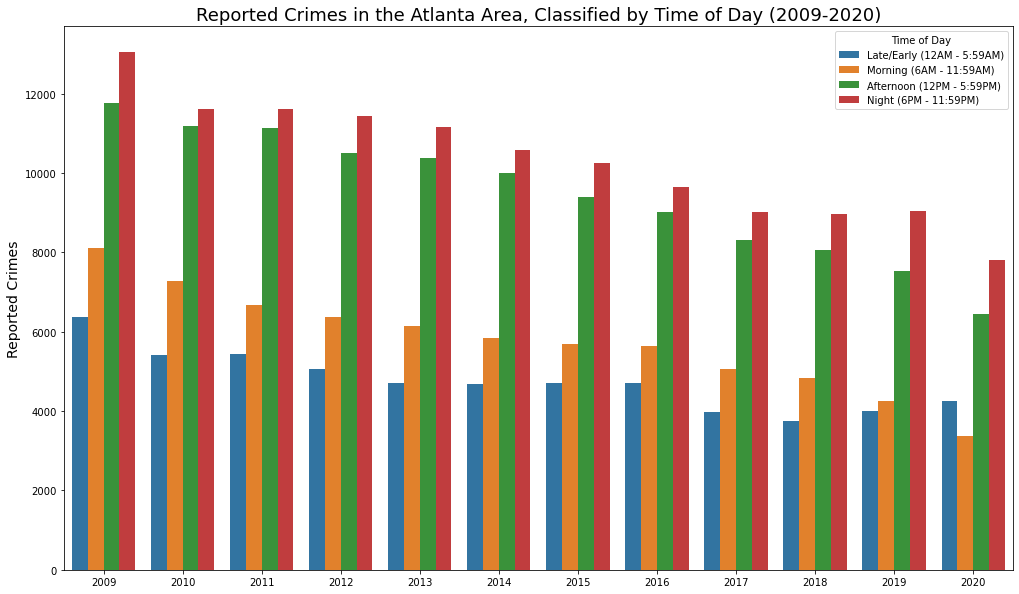

In [29]:
#Plot all years and times of crimes

#Set figure size with MatPlotlib
plt.figure(figsize=(17,10))
#Plot with seaborn
sns.barplot(x = 'occur_year', y = 'offense_id', hue = 'Time Category', data = time_offense_group_df)

#Move legend
plt.legend(bbox_to_anchor= (1, 1), title = "Time of Day" );

#Add title and labels for each axis and set font size. 
plt.title("Reported Crimes in the Atlanta Area, Classified by Time of Day (2009-2020)", fontsize = (18))
plt.ylabel("Reported Crimes", fontsize = (14))
plt.xlabel("")

plt.show()


Most crimes occuring in the afternoon/night segments, not after midnight. Not everything bad happens after midnight!

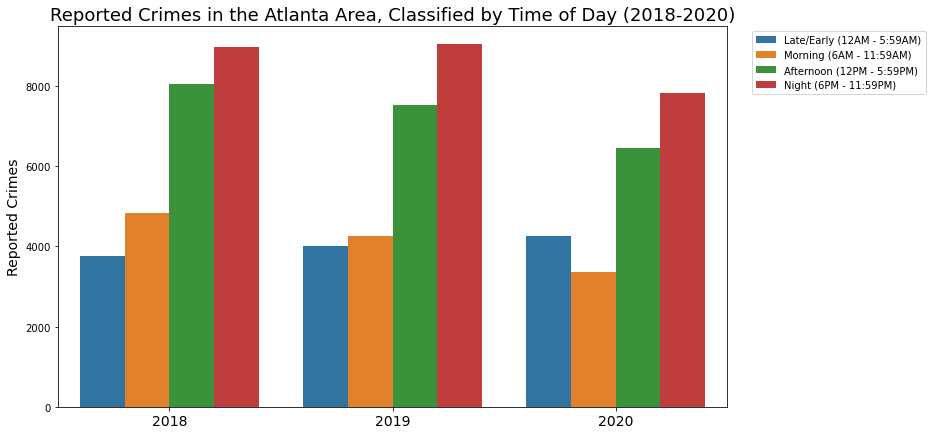

In [30]:
#Select 2018 - 2020 for closer analysis of above
three_years_time_df = time_offense_group_df.loc[(time_offense_group_df["occur_year"]==2018) |(time_offense_group_df["occur_year"]==2019)
                                              |(time_offense_group_df["occur_year"]==2020)]

#Use Matplotlib to set figure size ahead
plt.figure(figsize=(12,7))

#Plot with seaborn
sns.barplot(x = 'occur_year', y = 'offense_id', hue = 'Time Category', data = three_years_time_df)

#Move the legend off of the plot to stop it from blocking data
plt.legend(bbox_to_anchor= (1.03, 1) );

#Add title and labels for each axis and set font size. 
plt.title("Reported Crimes in the Atlanta Area, Classified by Time of Day (2018-2020)", fontsize = (18))
plt.ylabel("Reported Crimes", fontsize = (14))
plt.xlabel("")
plt.xticks(fontsize = (14))

plt.show()


Trends are the same overall except in 2020 morning doesn't follow the trend. It drops quite a lot, as well as afternoon and night segments.

In [31]:
#Group by the year and time of day, and type of crime, count the number of offenses 
time_type_group =good_time_df.groupby(["occur_year", "Time Category", "UC2_Literal"])['offense_id'].count()


#make time_type into a dataframe and reset the index
time_type_group_df = pd.DataFrame(time_type_group).reset_index()
time_type_group_df

#Can't graph 4 variables this way so I'll have to pull out the data year by year to graph it - start with 2018 - 2020 individually
eighteen_time_type_df = time_type_group_df.loc[(time_type_group_df["occur_year"]==2018)]

nineteen_time_type_df = time_type_group_df.loc[(time_type_group_df["occur_year"]==2019)]

twenty_time_type_df = time_type_group_df.loc[(time_type_group_df["occur_year"]==2020)]


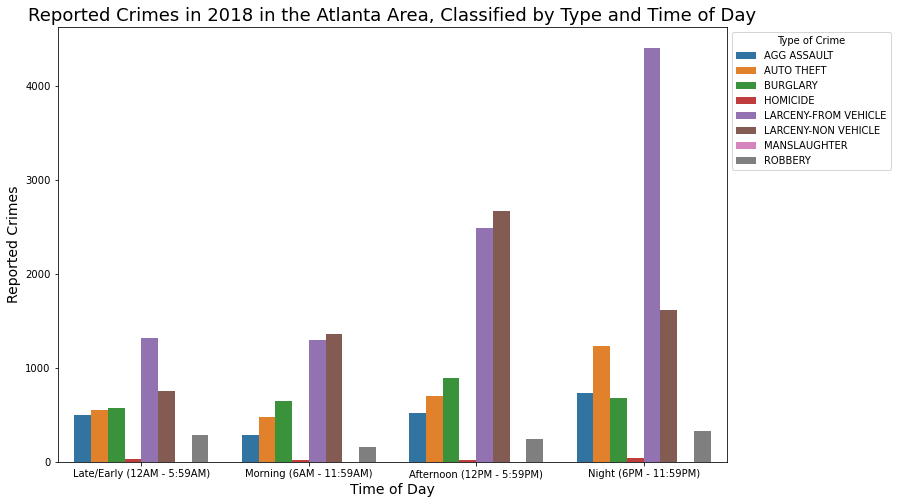

In [32]:
#Plot 2019 by time of day and type of crime
#Set figure size with MatPlotlib
plt.figure(figsize=(12,8))
#Plot with seaborn
sns.barplot(x = 'Time Category', y = 'offense_id', hue = 'UC2_Literal', data = nineteen_time_type_df)

#Move legend
plt.legend(bbox_to_anchor= (1, 1), title = "Type of Crime" );

#Add title and labels for each axis and set font size. 
plt.title("Reported Crimes in 2018 in the Atlanta Area, Classified by Type and Time of Day", fontsize = (18))
plt.ylabel("Reported Crimes", fontsize = (14))
plt.xlabel("Time of Day", fontsize = (14))
plt.show()


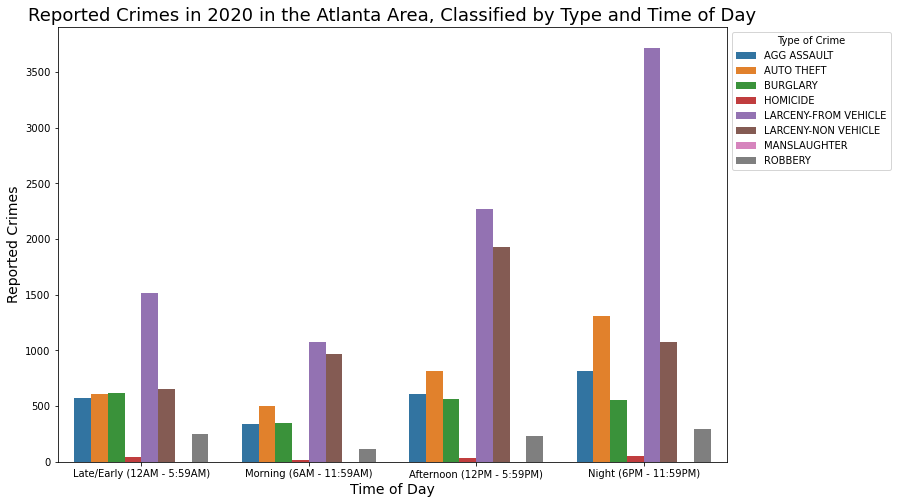

In [33]:
#Plot 2020 by time of day and type of crime
#Set figure size with MatPlotlib
plt.figure(figsize=(12,8))
#Plot with seaborn
sns.barplot(x = 'Time Category', y = 'offense_id', hue = 'UC2_Literal', data = twenty_time_type_df)

#Move legend
plt.legend(bbox_to_anchor= (1, 1), title = "Type of Crime" );

#Add title and labels for each axis and set font size. 
plt.title("Reported Crimes in 2020 in the Atlanta Area, Classified by Type and Time of Day", fontsize = (18))
plt.ylabel("Reported Crimes", fontsize = (14))
plt.xlabel("Time of Day", fontsize = (14))

plt.show()

In [34]:
#Pull only burglaries, since they appear to have gone down in 2020
burglary_df = good_time_df.loc[(good_time_df["UC2_Literal"]=="BURGLARY")]


#Get overall number of burglaries reported per year
burglary_counts = burglary_df["occur_year"].value_counts()

#Convert to df and add a separate index column
burglary_counts_df = pd.DataFrame(burglary_counts).reset_index()

#Rename columns
burglary_counts_df = burglary_counts_df.rename(columns={"index": "Year", "occur_year": "Reported Burglaries"})
burglary_counts_df



,Year,Reported Burglaries
0,2009,9075
1,2010,7985
2,2011,7404
3,2012,6151
4,2013,5947
5,2014,5466
6,2015,4784
7,2016,4376
8,2017,3394
9,2018,3022


In [35]:
#Make a loop to calculate the percent change year by year

#Set variable for the column for easier navigation
number_burglaries = burglary_counts_df["Reported Burglaries"]

#Set an empty list to collect the percent changes
percent_change_burg = []

#Loop through based on the column length
for i in range(len(number_burglaries)):
    
    #First number in the list will be zero, since there is no percent change for the first year
    if i==0:
        percent_change_burg.append(0)
    
    #Locate next row down, subtract previous row, divide by previous row and multiply by 100. Append list with calculations
    #Needs to stop at 2nd to last row
    if i <= (len(number_burglaries)-2):
        percent_burg_change = ((burglary_counts_df.iloc[(i+1),1] - burglary_counts_df.iloc[i,1])/burglary_counts_df.iloc[i,1] * 100)
        percent_change_burg.append(percent_burg_change)

#Make a copy of the original dataframe so it isn't modified
percent_change_burglaries_df = burglary_counts_df.copy()

#Add the percentage column to the new dataframe
percent_change_burglaries_df.insert(2, "Percent Change", percent_change_burg)

#Change the percent column to numeric
percent_change_burglaries_df["Percent Change"] = pd.to_numeric(percent_change_burglaries_df["Percent Change"])

#Take the absolule value to get rid of negative numbers
percent_change_burglaries_df["Percent Change"] = percent_change_burglaries_df["Percent Change"].abs()

#Format the percentage column
percent_change_burglaries_df["Percent Change"] = percent_change_burglaries_df["Percent Change"].map("{:,.0f}%".format)

#Display the new df
percent_change_burglaries_df

,Year,Reported Burglaries,Percent Change
0,2009,9075,0%
1,2010,7985,12%
2,2011,7404,7%
3,2012,6151,17%
4,2013,5947,3%
5,2014,5466,8%
6,2015,4784,12%
7,2016,4376,9%
8,2017,3394,22%
9,2018,3022,11%


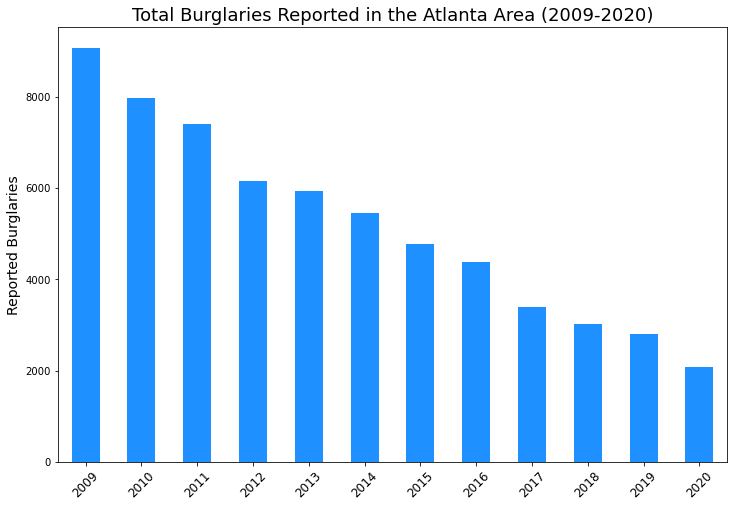

In [36]:
#Plot a bar chart of number of burglaries by year - just use the original counts; not the df
burglary_counts.plot(kind = "bar", color = "dodgerblue", figsize = (12,8))

#Add title and labels for each axis and set font size. Also set tick labels to sit at 45 degrees
plt.title("Total Burglaries Reported in the Atlanta Area (2009-2020)", fontsize = (18))
plt.ylabel("Reported Burglaries", fontsize = (14))
plt.xticks(rotation = 45, fontsize = (12))


plt.show()


Quite a drop in burglaries in 2020; break out across 2018-2020 for closer look.

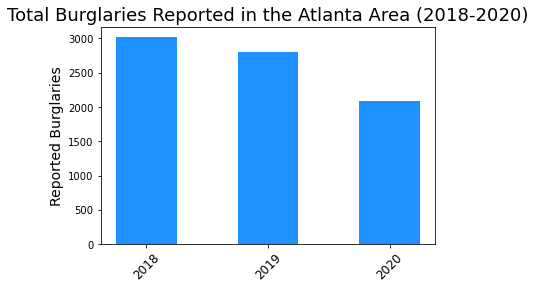

In [37]:
#Just pull 2018, 2019, 2020 for a more concentrated comparison of burglaries
three_years_burg = burglary_counts_df[(burglary_counts_df["Year"]==2018) |(burglary_counts_df["Year"]==2019)
                                      | (burglary_counts_df["Year"]==2020)]

#Set the chart type as bar, x-axis is the year, y is the number of burglaries, set color and width of bars
plt.bar(three_years_burg["Year"], three_years_burg["Reported Burglaries"], color = 'dodgerblue', align='center', width=0.5)

#Set placement of tick marks - just doing a pandas plot puts half year tick marks as well....
plt.xticks(three_years["Year"], rotation = 45, fontsize = (12))

#Add title and labels for each axis and set font size. Also set tick labels to sit at 45 degrees
plt.title("Total Burglaries Reported in the Atlanta Area (2018-2020)", fontsize = (18))
plt.ylabel("Reported Burglaries", fontsize = (14))
plt.xticks(rotation = 45, fontsize = (12))

plt.show()


2941 less crimes in 2020; 707 of those are burglaries.

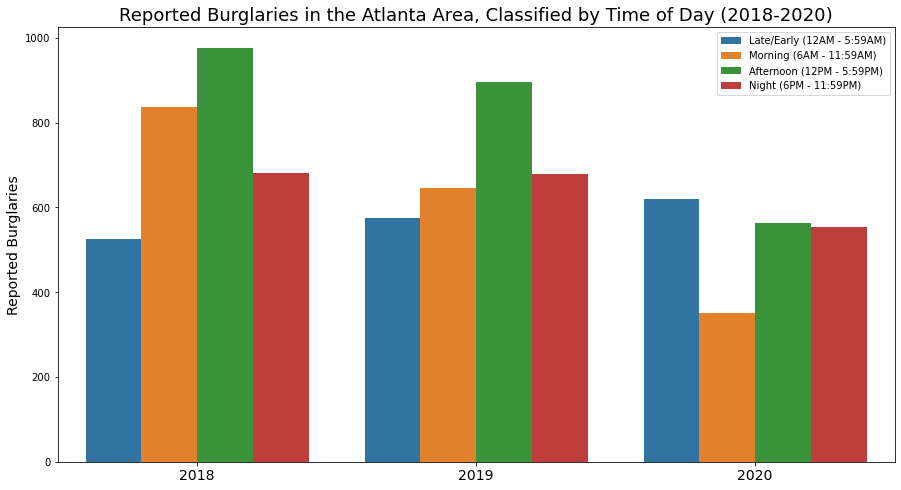

In [38]:
#Group by the year and time of day, count the number of burglaries 
time_burg_group =burglary_df.groupby(["occur_year", "Time Category"])['offense_id'].count()


#make time_offense into a dataframe and reset the index
time_burg_group_df = pd.DataFrame(time_burg_group).reset_index()


#Just pull 2018, 2019, 2020 for a more concentrated comparison of burglaries
three_years_burg_time_df =time_burg_group_df[(time_burg_group_df["occur_year"]==2018) |(time_burg_group_df["occur_year"]==2019) | (time_burg_group_df["occur_year"]==2020)]
# print(three_years_burg_time_df)


# Use Matplotlib to set figure size ahead
plt.figure(figsize=(15,8))

#Plot with seaborn
sns.barplot(x = 'occur_year', y = 'offense_id', hue = 'Time Category', data = three_years_burg_time_df)

#Move the legend off of the plot to stop it from blocking data
plt.legend(bbox_to_anchor= (1, 1) );

#Add title and labels for each axis and set font size. 
plt.title("Reported Burglaries in the Atlanta Area, Classified by Time of Day (2018-2020)", fontsize = (18))
plt.ylabel("Reported Burglaries", fontsize = (14))
plt.xlabel("")
plt.xticks(fontsize = 14)


plt.show()

Another interesting find: burglaries down in 2020 are down during morning, afternoon & night segments: possibly because folks were at home locked down vs at work.

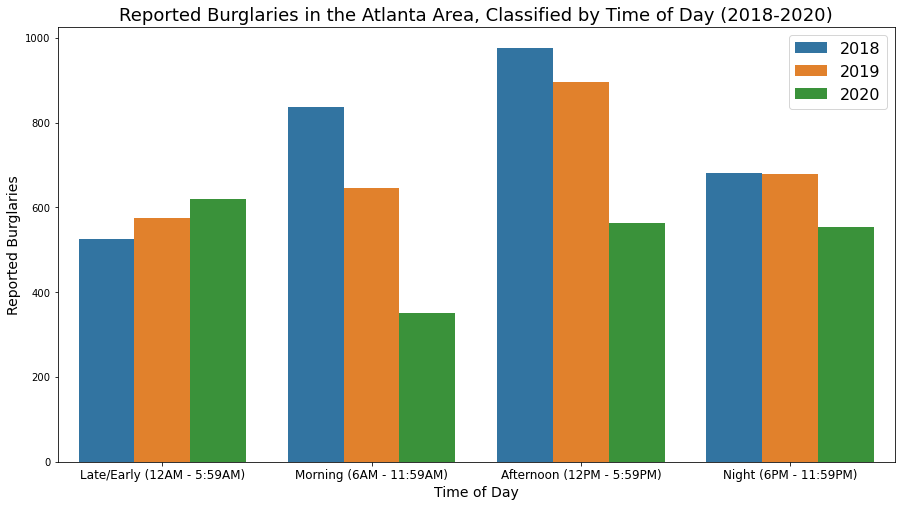

In [39]:
#Try plotting with time of day on the x and years in the legend
#Group by the year and time of day, count the number of burglaries 
time_burg_group =burglary_df.groupby(["occur_year", "Time Category"])['offense_id'].count()


#make time_offense into a dataframe and reset the index
time_burg_group_df = pd.DataFrame(time_burg_group).reset_index()


#Just pull 2018, 2019, 2020 for a more concentrated comparison of burglaries
three_years_burg_time_df =time_burg_group_df[(time_burg_group_df["occur_year"]==2018) |(time_burg_group_df["occur_year"]==2019) | (time_burg_group_df["occur_year"]==2020)]
# print(three_years_burg_time_df)


# Use Matplotlib to set figure size ahead
plt.figure(figsize=(15,8))

#Plot with seaborn
sns.barplot(x = 'Time Category', y = 'offense_id', hue = 'occur_year', data = three_years_burg_time_df)

#Move the legend off of the plot to stop it from blocking data
plt.legend(bbox_to_anchor= (1, 1), fontsize = (16) );

#Add title and labels for each axis and set font size. 
plt.title("Reported Burglaries in the Atlanta Area, Classified by Time of Day (2018-2020)", fontsize = (18))
plt.ylabel("Reported Burglaries", fontsize = (14))
plt.xlabel("Time of Day", fontsize = (14))
plt.xticks(fontsize = 12)

plt.show()


In [40]:
#Homicides went up in 2020, focus on & pull only homicides
homicide_df = good_time_df.loc[(good_time_df["UC2_Literal"]=="HOMICIDE")]


#Get overall number of homicides reported per year
homicide_counts = homicide_df["occur_year"].value_counts()


#Sort the series by the year, which is the index in this case
homicide_sort = homicide_counts.sort_index(ascending = True)

#Convert to df and add a separate index column
homicide_sort_df = pd.DataFrame(homicide_sort).reset_index()

#Rename columns
homicide_sort_df = homicide_sort_df.rename(columns={"index": "Year", "occur_year": "Reported Homicides"})
homicide_sort_df


,Year,Reported Homicides
0,2009,77
1,2010,89
2,2011,84
3,2012,83
4,2013,81
5,2014,87
6,2015,85
7,2016,112
8,2017,85
9,2018,88


More homicides in 2020 than any other year. Interesting point for project.


In [41]:
#Make a loop to calculate the percent change year by year

#Set variable for the column for easier navigation
number_homicides = homicide_sort_df["Reported Homicides"]

#Set an empty list to collect the percent changes
percent_change_homicide = []

#Loop through based on the column length
for i in range(len(number_homicides)):
    
    #First number in the list will be zero, since there is no percent change for the first year
    if i==0:
        percent_change_homicide.append(0)
    
    #Locate next row down, subtract previous row, divide by previous row and multiply by 100. Append list with calculations
    #Needs to stop at 2nd to last row
    if i <= (len(number_homicides)-2):
        percent_hom_change = ((homicide_sort_df.iloc[(i+1),1] - homicide_sort_df.iloc[i,1])/homicide_sort_df.iloc[i,1] * 100)
        percent_change_homicide.append(percent_hom_change)

#Make a copy of the original dataframe so it isn't modified
percent_change_homicides_df = homicide_sort_df.copy()

#Add the percentage column to the new dataframe
percent_change_homicides_df.insert(2, "Percent Change", percent_change_homicide)

#Change the percent column to numeric
percent_change_homicides_df["Percent Change"] = pd.to_numeric(percent_change_homicides_df["Percent Change"])

#Take the absolule value to get rid of negative numbers
percent_change_homicides_df["Percent Change"] = percent_change_homicides_df["Percent Change"].abs()

#Format the percentage column
percent_change_homicides_df["Percent Change"] = percent_change_homicides_df["Percent Change"].map("{:,.0f}%".format)

#Display the new df
percent_change_homicides_df

,Year,Reported Homicides,Percent Change
0,2009,77,0%
1,2010,89,16%
2,2011,84,6%
3,2012,83,1%
4,2013,81,2%
5,2014,87,7%
6,2015,85,2%
7,2016,112,32%
8,2017,85,24%
9,2018,88,4%


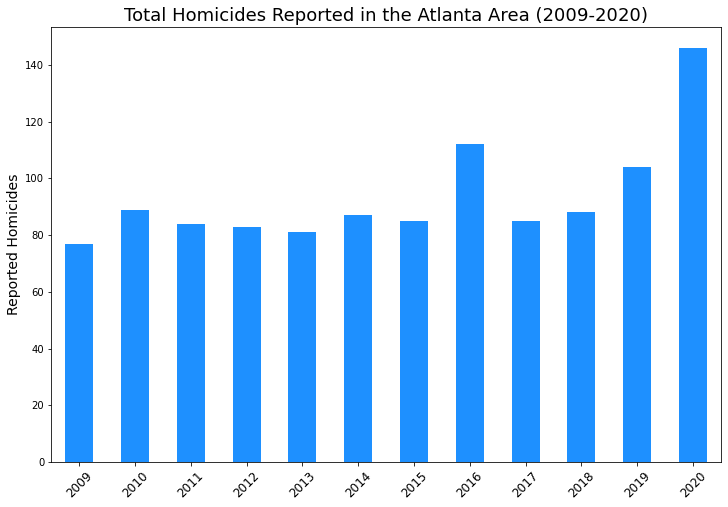

In [42]:
#Plot a bar chart of number of homicides by year - just use the counts series, don't need a df
homicide_sort.plot(kind = "bar", color = "dodgerblue", figsize = (12,8))

#Add title and labels for each axis and set font size. Also set tick labels to sit at 45 degrees
plt.title("Total Homicides Reported in the Atlanta Area (2009-2020)", fontsize = (18))
plt.ylabel("Reported Homicides", fontsize = (14))
plt.xticks(rotation = 45, fontsize = (12))


plt.show()

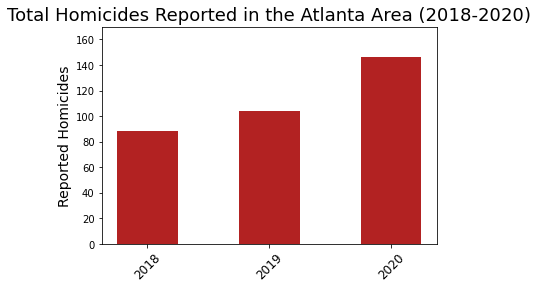

In [43]:
#Just pull 2018, 2019, 2020 for a more concentrated comparison of homicides
three_years_homicide = homicide_sort_df[(homicide_sort_df["Year"]==2018) |(homicide_sort_df["Year"]==2019)
                                        | (homicide_sort_df["Year"]==2020)]


#Set the chart type as bar, x-axis is the year, y is the number of burglaries, set color and width of bars
plt.bar(three_years_homicide["Year"], three_years_homicide["Reported Homicides"], color = 'firebrick', align='center', width=0.5)

#Set placement of tick marks - just doing a pandas plot puts half year tick marks as well....
plt.xticks(three_years_homicide["Year"], rotation = 45, fontsize = (12))

#Add title and labels for each axis and set font size. Also set tick labels to sit at 45 degrees
plt.title("Total Homicides Reported in the Atlanta Area (2018-2020)", fontsize = (18))
plt.ylabel("Reported Homicides", fontsize = (14))
plt.xticks(rotation = 45, fontsize = (12))

#Set y limits for more room atop bars
plt.ylim(0,170)

plt.show()